In [ ]:
# default_exp data.manipulate

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from fastscript import call_parse,Param,bool_arg
import math
import numpy as np
import os
import pandas as pd
import pydicom

# Data.Manipulate

> IO tools for manipulating medical images

In [ ]:
#test
try:
    import gdcm
    print('Successfully imported GDCM')
except ImportError:
    print('Could not import GDCM')

Successfully imported GDCM


## dcm2array

In [ ]:
#export
def dcm2array(path_to_dicom_dir=None, sort_by_slice_location=True):
    """
    Transform DICOM data into numpy array.

    Attributes:
        path_to_dicom_dir (str): Path to folder containing all dicom files for one patient
        sort_by_slice_location (bool): Whether to return array ordered by slice location

    Returns:
        pixel_array (arr): Array of pixel data
    """
    try:
        import gdcm

    except ImportError:
        print("GDCM needs to be installed.")
        print("Try: conda install -c conda-forge gdcm")

    else:
        df = pd.DataFrame()
        df['filename']= os.listdir(path_to_dicom_dir)
        df['pathname']= path_to_dicom_dir + df['filename']

        df['DS']=[pydicom.dcmread(x) for x in df['pathname']]
        df['SOPInstanceUID'] = [x.SOPInstanceUID for x in df['DS']]
        df['SliceLoc'] = [x.InstanceNumber for x in df['DS']]
        df['Pixels'] = [x.pixel_array for x in df['DS']]
        tempo = df['DS'][0]
        im_at = tempo.AcquisitionMatrix, tempo.PixelSpacing

        if sort_by_slice_location == True:
            df = df.sort_values(by=['SliceLoc'])
        pixel_array = np.dstack(np.asarray(df['Pixels']))

        return pixel_array
    return None

### Usage

`dcm2array` takes a path to one DICOM series (patient).

See the example below:

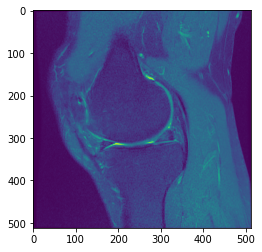

In [ ]:
import matplotlib.pyplot as plt
data_path = '../data/knee/'
try:
    image_array = dcm2array(path_to_dicom_dir = data_path, sort_by_slice_location=True)
    plt.imshow(image_array[:,:,6])
    plt.show()
except:
    print('could not load array')

## Resize

In [ ]:
#export
def crop(image_array, final_dims_in_pixels, zero_fill_mode=False):
    """
    Crop image data to final_dim_in_pixels 

    Attributes:
        image_array (float, np.array): 3D numpy array containing image data
        final_dim_in_pixels    (list): Final number of pixels in xyz dimensions. Example: [256, 256, 80]
        zero_fill_mode         (bool): If True, returns array filled with zeros

    Returns:
        cropped_image_array (arr): Resized array containing image data
    """
    
    dims = len(final_dims_in_pixels)
    original_dims_in_pixels = [image_array.shape[d] for d in range(len(image_array.shape))]

    # test if input and output dimensions match
    if dims != len(original_dims_in_pixels):
        raise ValueError("Dimensions of the input (" + str(len(image_array.shape)) +
                        ") do not match those of output (" + str(len(final_dims_in_pixels))+ ")")
    
    # test if desired final image is smaller than original
    if any(final_dims_in_pixels[d] > original_dims_in_pixels[d] for d in range(dims)):
        raise ValueError("Final dimensions are larger than original. Did you mean to `pad`?")


    cropped_image_array = np.zeros(image_array.shape)
    new_first_pixel = [0 for i in range(dims)]
    new_last_pixel = [0 for i in range(dims)]

    for dim in range(dims):
        new_first_pixel[dim] = int(math.floor((original_dims_in_pixels[dim] - final_dims_in_pixels[dim]) / 2)) 
        new_last_pixel[dim] = new_first_pixel[dim] + final_dims_in_pixels[dim]

    #for 2D:
    if dims == 2:
        cropped_image_array = image_array[new_first_pixel[0] : new_last_pixel[0],
                                          new_first_pixel[1] : new_last_pixel[1]]
    elif dims == 3:
        cropped_image_array = image_array[new_first_pixel[0] : new_last_pixel[0],
                                          new_first_pixel[1] : new_last_pixel[1],
                                          new_first_pixel[2] : new_last_pixel[2]]
    if zero_fill_mode:
        cropped_image_array = cropped_image_array*0.
    
    return(cropped_image_array)

### Usage

`crop` takes an image array and crops the array according to the input dimensions.

See the example below:

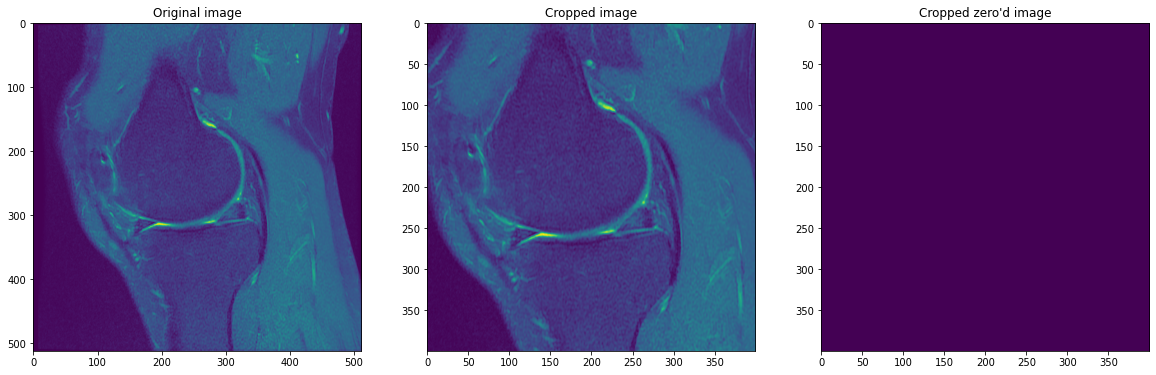

In [ ]:
#test
image_array = dcm2array(path_to_dicom_dir = data_path, sort_by_slice_location=True)
cropped_image = crop(image_array=image_array, final_dims_in_pixels=[400,400, 22])
cropped_zero_image = crop(image_array=image_array, final_dims_in_pixels=[400,400, 22], zero_fill_mode=True)

#original image
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.title('Original image')
plt.imshow(image_array[:,:,6])

#cropped image
plt.subplot(132)
plt.title('Cropped image')
plt.imshow(cropped_image[:,:,6])

#cropped image zero'd
plt.subplot(133)
plt.title("Cropped zero'd image")
plt.imshow(cropped_zero_image[:,:,6])

plt.show()

In [ ]:
#export
def pad(image_array, final_dims_in_pixels, zero_fill_mode=False):
    """
    Pad image data to final_dim_in_pixels 

    Attributes:
        image_array (float, np.array): 3D numpy array containing image data
        final_dim_in_pixels    (list): Final number of pixels in xyz dimensions. Example: [256, 256, 80]
        zero_fill_mode         (bool): If True, returns array filled with zeros

    Returns:
        padded_image_array (arr): Resized array containing image data
    """
    
    dims = len(final_dims_in_pixels)
    original_dims_in_pixels = [image_array.shape[d] for d in range(len(image_array.shape))]

    # test if input and output dimensions match
    if dims != len(original_dims_in_pixels):
        raise ValueError("Dimensions of the input (" + str(len(image_array.shape)) +
                        ") do not match those of output (" + str(len(final_dims_in_pixels))+ ")")
    
    # test if desired final image is larger than original
    if any(final_dims_in_pixels[d] < original_dims_in_pixels[d] for d in range(dims)):
        raise ValueError("Final dimensions are smaller than original. Did you mean to `crop`?")

    padded_image_array = np.zeros(final_dims_in_pixels)
    new_first_image_pixel = [0 for i in range(dims)]
    new_last_image_pixel = [0 for i in range(dims)]

    for dim in range(dims):
        new_first_image_pixel[dim] = int(math.floor((final_dims_in_pixels[dim] - original_dims_in_pixels[dim]) / 2)) 
        new_last_image_pixel[dim] = new_first_image_pixel[dim] + original_dims_in_pixels[dim]

    #for 2D:
    if dims == 2:
        padded_image_array [new_first_image_pixel[0] : new_last_image_pixel[0],
                            new_first_image_pixel[1] : new_last_image_pixel[1]] = image_array
    elif dims == 3:
        padded_image_array [new_first_image_pixel[0] : new_last_image_pixel[0],
                            new_first_image_pixel[1] : new_last_image_pixel[1],
                            new_first_image_pixel[2] : new_last_image_pixel[2]] = image_array
    if zero_fill_mode:
        padded_image_array = padded_image_array*0.
    
    return(padded_image_array)

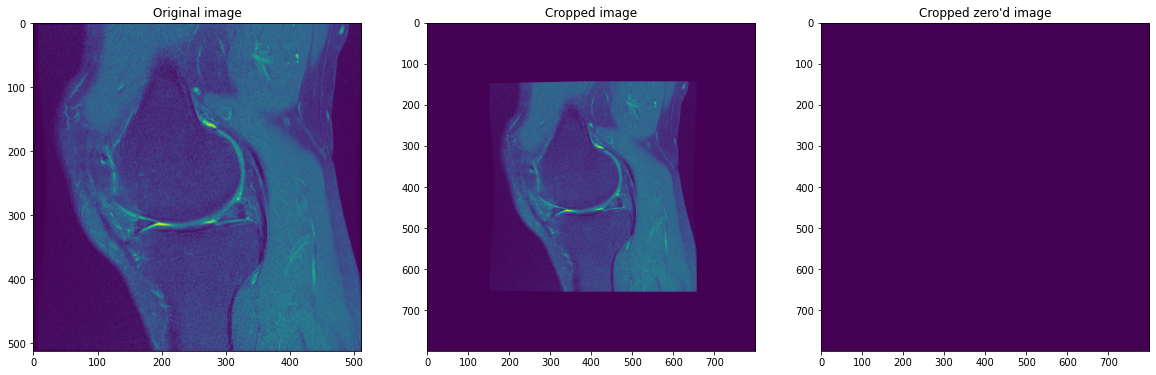

In [ ]:
image_array = dcm2array(path_to_dicom_dir = data_path, sort_by_slice_location=True)
padded_image = pad(image_array=image_array, final_dims_in_pixels=[800,800,22])
padded_zero_image = pad(image_array=image_array, final_dims_in_pixels=[800,800, 22], zero_fill_mode=True)

#original image
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.title('Original image')
plt.imshow(image_array[:,:,6])

#padded image
plt.subplot(132)
plt.title('Padded image')
plt.imshow(padded_image[:,:,6])

#padded image zero'd
plt.subplot(133)
plt.title("Padded zero'd image")
plt.imshow(padded_zero_image[:,:,6])

plt.show()